# Analyse 0.3 torching data

# Summary
The MICS sensor readings are quite similar across the boxes.
Alphasense readings vary widely between the different boxes, and most of the readings result in peculiar values after conversion. There are many sensors that post a zero reading throughout the test.
The results from the R^2 and S-K tests are similarly poor for Alphasense, while they appear reasonably good for MICS.  

For a quick overall picture of what is going on, jump to the "Results" section at the bottom of the notebook.

Although one of the goals was to make corrections to the series to get them all to provide sensible values, I was unable to do this due to the readings being so peculiar (Alphasense: zero readings and full voltage readings; MICS: R0 calibration unreliable due to there being no stable starting period when to estimate this).

## Issues
1. Data potentially incomplete, and readings are very weird
  - I see only 76-78 sets of readings in each log file - is this right?
2. Most Alphasense readings had some issues -- zero readings from one electrode and full voltage from the other.
3. MICS baseline resistance (R0) cannot be estimated properly, as there is no stable starting period in readings, regardless of the stated 1-minute ambient period
    - possibly missing the ambient period?


## Pre-declared issues
 - The boxes don't have MICS RED readings - the sensor reported as RED is simply reporting the same as OX -- so no CO readings, only NO2
 - MICS resitances are 1.49k on the NO2 and 149k on the CO
 - There are no temperature or humidity readings provided
 - No readings are provided from Winsen PM and Alphasense OPC-N2 sensors

Batches have the following box IDs:
    Batch 1: 27, 26, 24, 28, 22
    Batch 2: 25, 23, 29, 30, 21


## Potentially broken sensors
 Batch 1:
 - ID 27: Alphasense CO AUX sensor - zero values throughout
 - ID 26: Alphasense CO AUX sensor - zero values throughout
 - ID 22: Alphasense CO AUX sensor - zero values throughout
 
 Batch 2:
 - ID 25: Alphasense CO AUX sensor - zero values throughout
 - ID 23: Alphasense CO AUX sensor - zero values throughout, MICS sensors (or sensor) zero throughout
 - ID 29: MICS sensors (or sensor) zero throughout

**ALTERNATIVE EXPLANATION** - the Alphasense AUX and WE readings may have been mislabeled, especially as the readings start high. This would suggest that some sensors have CO readings 0 throughout.

### Potentially reversed AUX and WE electrodes:
  - CO: all except box 24
  - NO2: all except box 30


## Assumptions
 - The temperature and humidity are assumed not to affect the sensor
   readings in these tests.
 - The box ID numbers differ from those in the calibration sheets PDF
     - Lev mentioned that the numbering changed, so e.g. 27 -> old ID 7
     - given this, it is assumed that the ID numbers in the calibration
       sheets are given by current ID value minus 20.
 - With no information on reading frequency, the different test-stage cut-offs are determined by dividing the total number of readings by five, which gives us an estimate of readings per minute 
     - the readings 0 to N/5-1 are assumed to happen during the ambient stage
     - the readings N/5 to 2N/5-1 are assumed to take place during torching
     - the remaining readings are when torch is off
 - MICS conversion to ppb: The MICS conversion from R1/R0 resistance ratio to ppb values is done using estimated conversion functions, estimated from graphs in the MICS sensor's datasheet.
     
## Things to improve if time
- Converted log files to data csv files in bash: grep '^GASCAL' serial0.log > serial0.csv
- a better approach would be to use regexp functionalities in Python to do this
- the individual sensor images are unnecessary, could scrap them

---

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns

import math
import scipy.stats
from sklearn.metrics import r2_score

# Matlplotlib customizations
plt.rcParams['figure.figsize'] = (10,4)

## Conversion functions

### Alphasense calibration data

In [4]:
# Calibration sheet data
cal = pd.DataFrame(pd.read_csv('V0_3_calibration.csv'))

In [5]:
cal.head()

,ID,OPCID,CAS_AFEID,NO2_WE_ELECTRONIC_ZERO,NO2_WE_SENSOR_ZERO,NO2_AUX_ELECTRONIC_ZERO,NO2_AUX_SENSOR_ZERO,NO2_SENSITIVITY_mV_ppb,NO2_SENSITIVITY_nA_ppb,NO2_PCB_GAIN,CO_WE_ELECTRONIC_ZERO,CO_WE_SENSOR_ZERO,CO_AUX_ELECTRONIC_ZERO,CO_AUX_SENSOR_ZERO,CO_SENSITIVITY_mV_ppb,CO_SENSITIVITY_nA_ppb,CO_PCB_GAIN
0,21,'17930509','12-000011',288,-67,303,-11,0.218,-0.299,-0.73,281,33,281,-5,0.248,0.311,0.8
1,22,'176930507','12-000030',293,8,298,0,0.203,-0.279,-0.73,293,121,285,-12,0.236,0.296,0.8
2,23,'176390807','12-000034',291,1,292,0,0.194,-0.267,-0.73,265,143,266,-13,0.231,0.289,0.8
3,24,'176930503','12-000035',302,6,289,2,0.194,-0.266,-0.73,277,132,268,-9,0.236,0.296,0.8
4,25,'176930504','12-000028',297,0,309,0,0.187,-0.257,-0.73,268,43,272,7,0.226,0.283,0.8


### Alphasense CO conversion function that selects correct calibration values

This follows the explanation given by Dr Wah On Ho from Alphasense, except using the nA/ppb sensitivity (instead of mV/ppb) with the mV/nA gain value. (as that makes sense given the units)

In [6]:
def convert_co_ID(ID=None, CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C

    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].CO_WE_ELECTRONIC_ZERO;
    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].CO_AUX_ELECTRONIC_ZERO;
    #CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_mV_ppb; # mv/ppb
    CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_nA_ppb; # nA/ppb
    CO_GAIN = cal.loc[cal['ID'] == ID].CO_PCB_GAIN;

    scaled_working = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/CO_GAIN
    
    scaled_aux =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / CO_GAIN*temp_correction
    
    return  (scaled_working - scaled_aux)/CO_SENSITIVITY

In [488]:
def convert_co_ID_reverse(ID=None, CO_aux_mv=None, CO_working_mv=None, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C

    CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].CO_WE_ELECTRONIC_ZERO;
    CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].CO_AUX_ELECTRONIC_ZERO;
    #CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_mV_ppb; # mv/ppb
    CO_SENSITIVITY = cal.loc[cal['ID'] == ID].CO_SENSITIVITY_nA_ppb; # nA/ppb
    CO_GAIN = cal.loc[cal['ID'] == ID].CO_PCB_GAIN;
  
    scaled_aux =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / CO_GAIN*temp_correction
    
    scaled_working = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/CO_GAIN
    
    return  (scaled_working - scaled_aux)/CO_SENSITIVITY

### Alphasense NO2 conversion function that selects correct calibration values

This follows the explanation given by Dr Wah On Ho from Alphasense, **except using the nA/ppb sensitivity (instead of mV/ppb) with the mV/nA gain value.**

In [7]:
def convert_no2_ID(ID=None, NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # For A4 sensors: temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_AUX_ELECTRONIC_ZERO;
    #NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb
    NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_nA_ppb; # nA/ppb
    NO2_GAIN = cal.loc[cal['ID'] == ID].NO2_PCB_GAIN;
    
    scaled_working = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)/NO2_GAIN
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_GAIN*temp_correction
        
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY

In [8]:
# Amibient temperature "simple correction" (p.2 of AAN 803), without PCB gain
def convert_no2_ambient(ID=None, NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_AUX_ELECTRONIC_ZERO;
    NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb

    scaled_working = NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)*temp_correction 
    
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY    
    

In [483]:
# Amibient temperature "simple correction" (p.2 of AAN 803), without PCB gain
def convert_no2_ambient_reverse(ID=None, NO2_aux_mv=None, NO2_working_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_WE_ELECTRONIC_ZERO;
    NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = cal.loc[cal['ID'] == ID].NO2_AUX_ELECTRONIC_ZERO;
    NO2_SENSITIVITY = cal.loc[cal['ID'] == ID].NO2_SENSITIVITY_mV_ppb; # mv/ppb

    scaled_working = NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_aux =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)*temp_correction 
    
    return  (scaled_working - scaled_aux)/NO2_SENSITIVITY    

## MICS NO2 conversions
###  MICS voltage to resistance conversion function

In [333]:
# Conversion based on the following note from Lev:

  #mics conversion for the 0.2 torching was this. 
  #you need to change the resitances to be are 1.49k on the NO2 
  # and 149k on the  CO for 0.3   

  # convert mics from voltage to resistance.,
     # Resistance divider was used\n",
     # http://www.ohmslawcalculator.com/voltage-divider-calculator,
     # Vs is 5V, R1 is 1 megaOhm for CO
     # v_out = V_s * R_2 / (R_1 + R_2)
   
     # R_2   = (V_out/V_s) (R_1 + R_2)
     # R_2( 1- (V_out/V_s))   = (V_out/V_s) R_1
     # R_2 =  (V_out/V_s) R_1 / ( 1- (V_out/V_s))
     # R_2 =  R_1 / ((V_s/V_out) - 1)
    
# So assuming R1 = 1.49k Ohm, and with other details the same
def resistance_from_voltage(v_out, r_1=1.49*1000.0, vs=5.0*1000):
    if v_out == 0:
        return np.NaN
    return r_1 / ((vs/v_out) - 1.0)

### MICS resistance-ratio values to ppm

#### Conversion function estimation
Given the non-linear relationship between the MICS sensor readings and gas concentration values, a function for conversion was estimated, using MICS datasheet graphs. 

For the CO function, I shall fit a 2nd order polynomial to the inverse of the ppm values, as the ppm values appear to be negative powered function of Rs/R0 values. For NO2, ppm appears to be a polynomial function of the Rs/R0 values, so the fitting can be done without inverting the ppm series.

This means that, once the polynomials are applied to the Rs/R0 values from the MICS sensors, the result is the ppm value for NO2, but for CO the result has to be inverted to get the ppm value. 

In [334]:
# Table of values
mics_conv = pd.DataFrame()

# Conversion table values read from graphs on p.1 of MICS datasheet

# Estimating CO polynomial coefficients
co_rsr0 = [0.01,0.07,0.1,0.6,0.7,0.8,0.9,1,2,3.5]
co_ppm = [1000,100,70,8,7,6,5,4.5,2,1]
# Inverting co_ppm series
inv_co_ppm = [1/x for x in co_ppm]
# Fitting a polynomial through the points, and saving the coefficients
co_conv = np.polyfit(co_rsr0,inv_co_ppm,2)
mics_conv['CO'] = [co_conv[2],co_conv[1],co_conv[0]]

# Estimating NO2 polynomial coefficients
no2_rsr0 = [0.065,0.19,0.31,0.5,0.65,1,1.9,6.6,10]
no2_ppm = [0.01,0.03,0.05,0.08,0.1,0.16,0.3,1,1.6]
no2_conv = np.polyfit(no2_rsr0,no2_ppm,2)
mics_conv['NO2'] = [no2_conv[2],no2_conv[1],no2_conv[0]]

print("\nThe polynomial coefficient matrix for MICS conversions is")
print(mics_conv)


The polynomial coefficient matrix for MICS conversions is
         CO       NO2
0 -0.004898  0.009150
1  0.201567  0.140236
2  0.024526  0.001829


#### MICS conversion functions from resistance values to ppm and ppb

In [335]:
# Functions for converting MICS R1/R0 values to ppm
def mics_co_ppm(R=None,R0=None):
    if R0 == 0:
        return pd.NaN
    return 1/(mics_conv['CO'][0] + mics_conv['CO'][1]*(R/R0) + mics_conv['CO'][2]*(R/R0)**2)

def mics_no2_ppm(R=None,R0=None):
    if R0 == 0:
        return pd.NaN
    return mics_conv['NO2'][0] + mics_conv['NO2'][1]*(R/R0) + mics_conv['NO2'][2]*(R/R0)**2

# functions for conversion to ppb
def mics_co_ppb(R=None,R0=None):
    if R0 == 0:
        return pd.NaN
    return (1/(mics_conv['CO'][0] + mics_conv['CO'][1]*(R/R0) + mics_conv['CO'][2]*(R/R0)**2))*1000

def mics_no2_ppb(R=None,R0=None):
    if R0 == 0:
        return pd.NaN
    return (mics_conv['NO2'][0] + mics_conv['NO2'][1]*(R/R0) + mics_conv['NO2'][2]*(R/R0)**2)*1000

___

## Batch 1, serial 0 [Sensor box 27]

In [336]:
df_10 = pd.read_csv("batch1/serial0.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

In [337]:
df_10.head()

,GASCAL,ID,MICSNO2,MICSCO,ALPHANO2_AUX,ALPHANO2_WORKING,ALPHACO_AUX,ALPHACO_WORKING
0,GASCAL,27,1708.425,1709.231,3300.0,2444.982,0.0,3300.0
1,GASCAL,27,1569.817,1592.381,3300.0,2440.146,0.0,3300.0
2,GASCAL,27,1515.824,1517.436,3300.0,2443.370,0.0,3300.0
3,GASCAL,27,1426.374,1443.297,3300.0,2444.982,0.0,3300.0
4,GASCAL,27,1366.740,1366.740,3300.0,2443.370,0.0,3300.0


In [338]:
#print("\nThe descriptive statistics for the data series are:\n")
#print(df_10.describe())

**Observations:**
- The Alphasense CO AUX sensor appears to be broken
- As reported, the MICS sensor readings are both for OX, so NO2 readings


### Conversions to ppb

#### CO (only Alphasense, but AUX broken)

#### Using the conversion function

In [526]:
df_10['co_ppb'] = df_10[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_10['co_ppb_reverse'] = df_10[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

In [527]:
df_10.co_ppb.head()

0    15472.846442
1    15472.846442
2    15472.846442
3    15472.846442
4    15472.846442
Name: co_ppb, dtype: float64

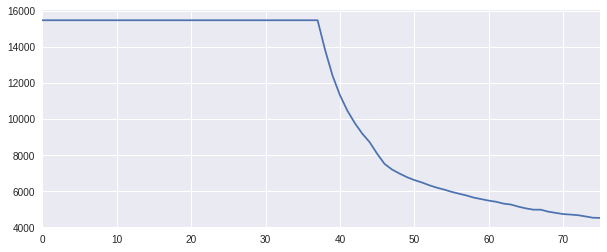

In [529]:
df_10.co_ppb.plot()

### NO2 (Alphasense and MICS)

#### Alphasense NO2 conversion to ppm

In [530]:
#df_10['no2_ppb'] = df_10[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_10['no2_ppb'] = df_10[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_10['no2_ppb_reverse'] = df_10[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

In [343]:
#df_10.no2_ppb.head()

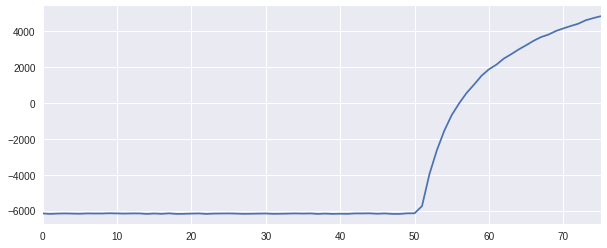

In [344]:
df_10.no2_ppb.plot()

#### Observations
- The values look completely nonsensical, there is **something wrong with the experiment or the sensor**
- It is possible that the conversion is off, somewhat, but the general patterns of the readings are not good either

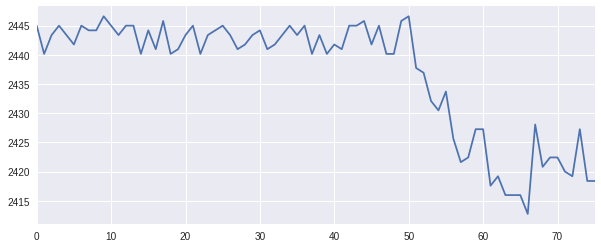

In [345]:
df_10.ALPHANO2_WORKING.plot()

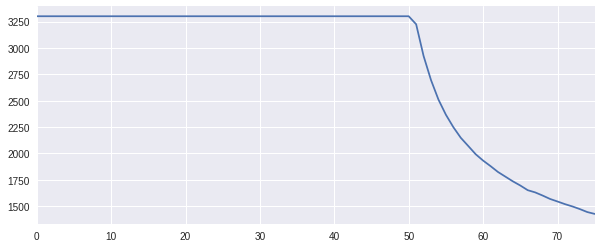

In [346]:
df_10.ALPHANO2_AUX.plot()

### MICS NO2 conversion to ppm

In [347]:
#df_10.MICSNO2.plot()

In [348]:
# Resistances
df_10['NO2_mics_R1'] = df_10[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_10.MICSNO2.count()
minute = math.floor(obsN/5)
df_10['NO2_mics_R0'] = df_10.NO2_mics_R1[0:minute].mean()

# Converting to ppm and ppb
#df_10['NO2_mics_ppm'] = df_10[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppm(x.values[0], x.values[1]), axis=1)
df_10['NO2_mics_ppb'] = df_10[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)

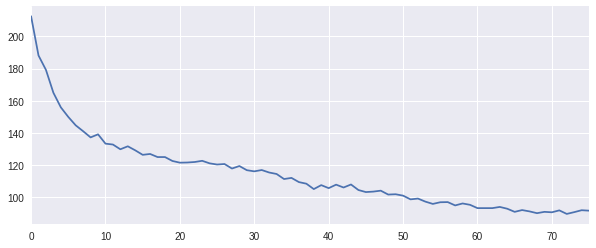

In [349]:
df_10.NO2_mics_ppb.plot()

### Observations
- **values are not sensible** - the converted are bad, but so is the pattern of the raw readings
- the first minute (or the first N/5 observations) are not stable, so R0 cannot be determined from them

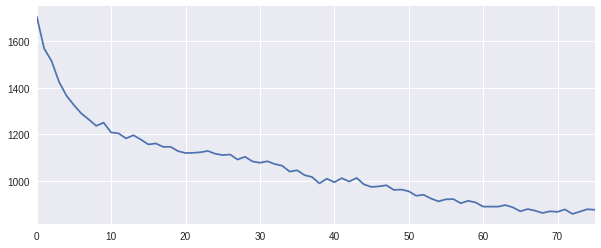

In [350]:
# Even the raw data looks odd - it starts decreasing immediately - NOT what I saw previously
df_10.MICSNO2.plot()

---

##  Batch 1, serial 1 [Sensor box 26]

In [351]:
df_11 = pd.read_csv("batch1/serial1.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])
#df_11.head()

### Values in ppb

#### CO (only Alphasense, but AUX broken)

In [531]:
df_11['co_ppb'] = df_11[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_11['co_ppb_reverse'] = df_11[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

In [353]:
#df_11.co_ppb.head()

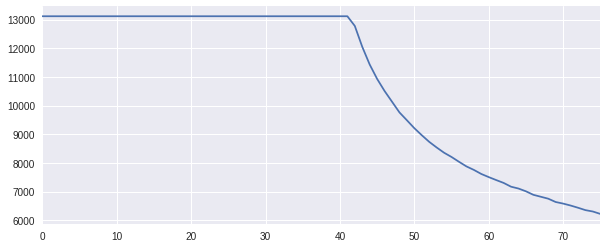

In [354]:
df_11.co_ppb.plot()

## Alphasense NO2 values

In [532]:
df_11['no2_ppb'] = df_11[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_11['no2_ppb_reverse'] = df_11[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

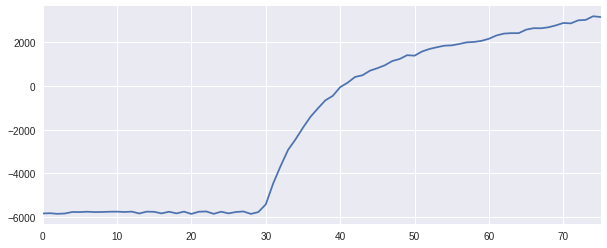

In [356]:
df_11.no2_ppb.plot()

## MICS NO2 values

In [357]:
# Resistances
df_11['NO2_mics_R1'] = df_11[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_11.MICSNO2.count()
minute = math.floor(obsN/5)
df_11['NO2_mics_R0'] = df_11.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_11['NO2_mics_ppb'] = df_11[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)

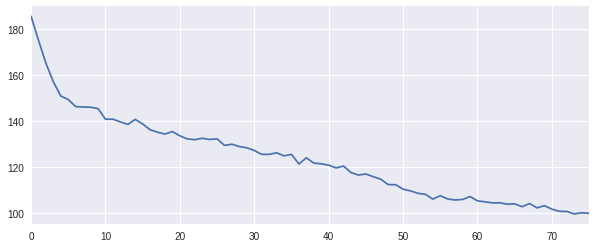

In [358]:
df_11.NO2_mics_ppb.plot()

Similar to sensor 27 (the first one tested), very different from Alphasense

---

# Batch 1, serial 2 [Sensor box 24]

In [533]:
df_12 = pd.read_csv("batch1/serial2.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_12['co_ppb'] = df_12[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_12['co_ppb_reverse'] = df_12[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)


# Alphasense NO2 in ppb
df_12['no2_ppb'] = df_12[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_12['no2_ppb_reverse'] = df_12[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)


# MICS NO2 in ppb
# Resistances
df_12['NO2_mics_R1'] = df_12[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_12.MICSNO2.count()
minute = math.floor(obsN/5)
df_12['NO2_mics_R0'] = df_12.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_12['NO2_mics_ppb'] = df_12[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


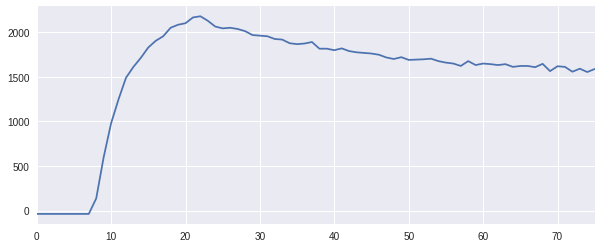

In [537]:
df_12.co_ppb.plot()

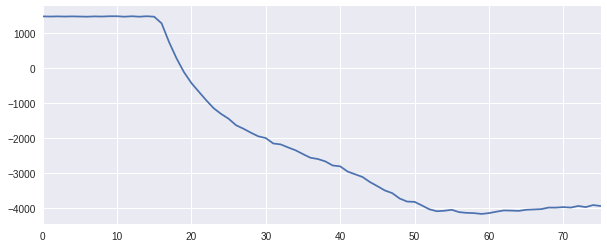

In [535]:
df_12.no2_ppb.plot()

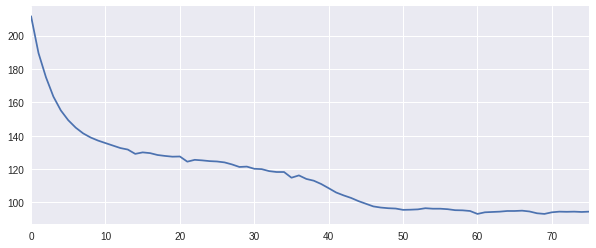

In [362]:
df_12.NO2_mics_ppb.plot()

### Observations
- CO series looks promising
- NO2 series look odd, as before

# Batch 1, serial 3 [Sensor box 28]

In [538]:
df_13 = pd.read_csv("batch1/serial3.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_13['co_ppb'] = df_13[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_13['co_ppb_reverse'] = df_13[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_13['no2_ppb'] = df_13[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_13['no2_ppb_reverse'] = df_13[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)


# MICS NO2 in ppb
# Resistances
df_13['NO2_mics_R1'] = df_13[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_13.MICSNO2.count()
minute = math.floor(obsN/5)
df_13['NO2_mics_R0'] = df_13.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_13['NO2_mics_ppb'] = df_13[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


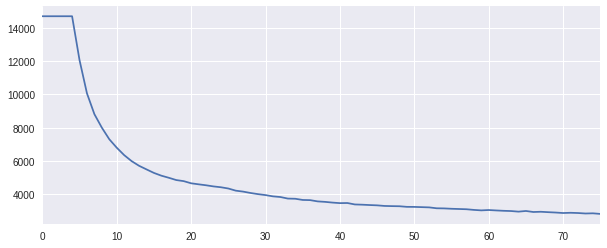

In [364]:
df_13.co_ppb.plot()

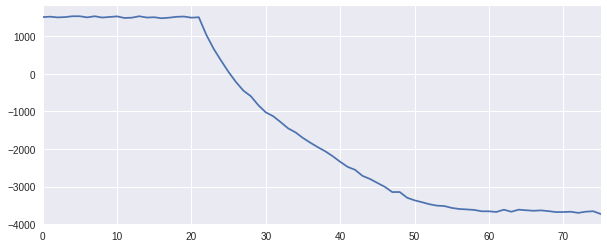

In [365]:
df_13.no2_ppb.plot()

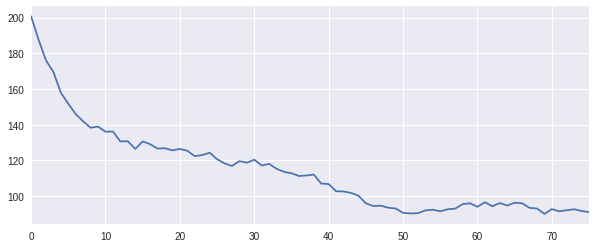

In [366]:
df_13.NO2_mics_ppb.plot()

### Observations
- CO series looks bad, something odd with the setup perhaps
- NO2 series look odd, as before

# Batch 1, serial 5 [Sensor box 22]  

In [539]:
df_15 = pd.read_csv("batch1/serial5.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_15['co_ppb'] = df_15[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_15['co_ppb_reverse'] = df_15[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_15['no2_ppb'] = df_15[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_15['no2_ppb_reverse'] = df_15[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb
# Resistances
df_15['NO2_mics_R1'] = df_15[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_15.MICSNO2.count()
minute = math.floor(obsN/5)
df_15['NO2_mics_R0'] = df_15.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_15['NO2_mics_ppb'] = df_15[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


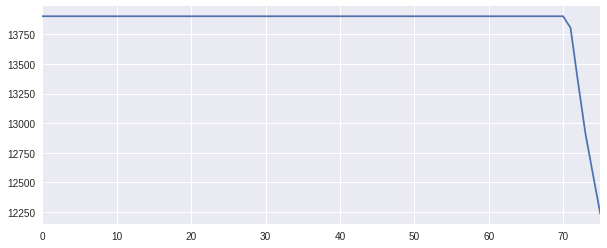

In [368]:
df_15.co_ppb.plot()
#df_15.no2_ppb.plot()
#df_15.NO2_mics_ppb.plot()

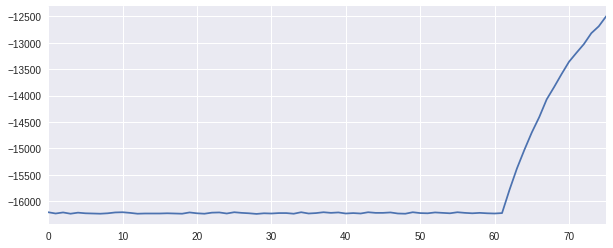

In [369]:
df_15.no2_ppb.plot()

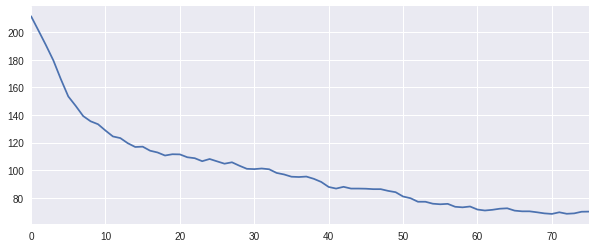

In [370]:
df_15.NO2_mics_ppb.plot()

### Observations
- CO series looks bad, AUX electrode appears broken (zero results)
- NO2 series look odd, as before
- MICS NO2 series looks similar to other MICS series, though 

---

# Batch 2, serial 0 [Sensor box 25]  

In [540]:
df_20 = pd.read_csv("batch2/serial0.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_20['co_ppb'] = df_20[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_20['co_ppb_reverse'] = df_20[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_20['no2_ppb'] = df_20[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_20['no2_ppb_reverse'] = df_20[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb
# Resistances
df_20['NO2_mics_R1'] = df_20[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_20.MICSNO2.count()
minute = math.floor(obsN/5)
df_20['NO2_mics_R0'] = df_20.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_20['NO2_mics_ppb'] = df_20[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


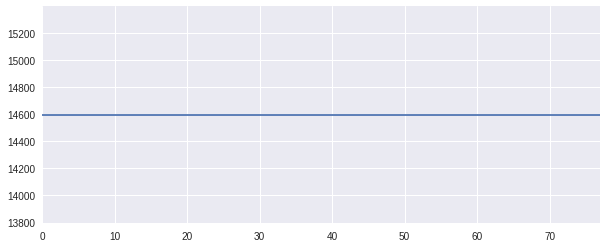

In [372]:
df_20.co_ppb.plot()
#df_20.no2_ppb.plot()
#df_20.NO2_mics_ppb.plot()

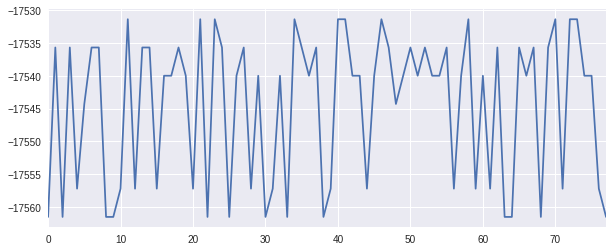

In [373]:
df_20.no2_ppb.plot()

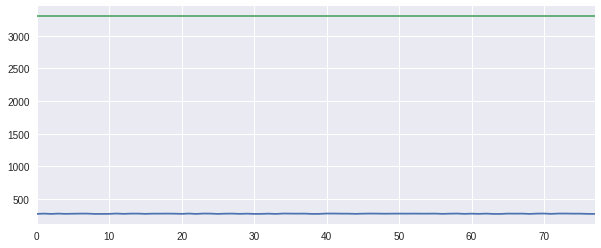

In [374]:
df_20.ALPHANO2_WORKING.plot()
df_20.ALPHANO2_AUX.plot()

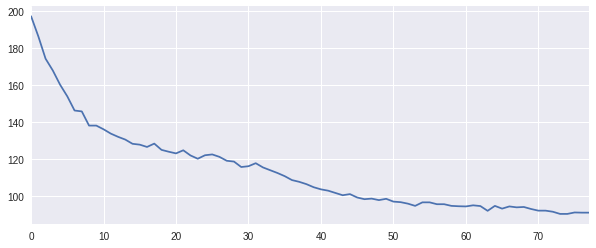

In [375]:
df_20.NO2_mics_ppb.plot()

### Observations
- CO series flat -- AUX electrode zero, WE full (3300 mV)
- Alphasense NO2 volatile -- WE volatile, AUX full (3300 mV)
- MICS NO2 series looks similar to other MICS series, though 

# Batch 2, serial 1 [Sensor box 23]  

In [541]:
df_21 = pd.read_csv("batch2/serial1.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_21['co_ppb'] = df_21[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_21['co_ppb_reverse'] = df_21[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_21['no2_ppb'] = df_21[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_21['no2_ppb_reverse'] = df_21[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb - SERIES ZERO, SO GET DIV BY ZERO ERRORS
# Resistances
df_21['NO2_mics_R1'] = df_21[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_21.MICSNO2.count()
minute = math.floor(obsN/5)
df_21['NO2_mics_R0'] = df_21.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_21['NO2_mics_ppb'] = df_21[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


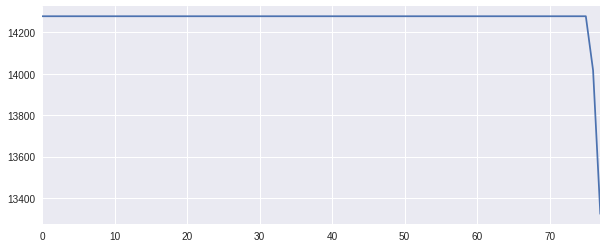

In [378]:
df_21.co_ppb.plot()
#df_21.no2_ppb.plot()
#df_21.NO2_mics_ppb.plot()

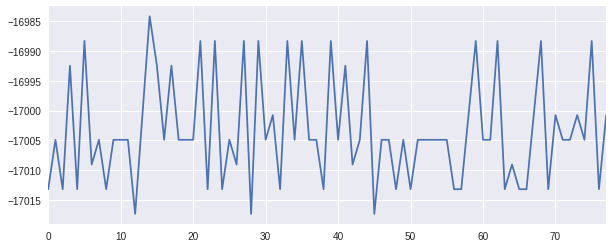

In [379]:
df_21.no2_ppb.plot()

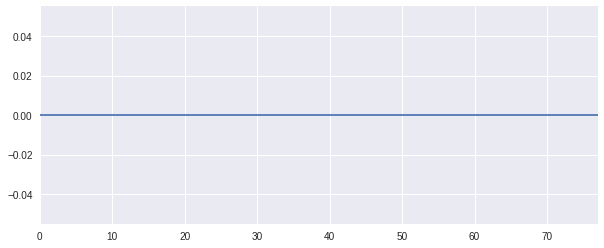

In [380]:
df_21.MICSNO2.plot()

### Observations
- CO series flat except very end -- AUX electrode zero, WE mostly full (3300 mV)
- Alphasense NO2 volatile -- WE volatile, AUX full (3300 mV)
- MICS NO2 sensors with zero reading

# Batch 2, serial 2 [Sensor box 29]  

In [542]:
df_22 = pd.read_csv("batch2/serial2.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_22['co_ppb'] = df_22[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_22['co_ppb_reverse'] = df_22[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_22['no2_ppb'] = df_22[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_22['no2_ppb_reverse'] = df_22[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb - SERIES ZERO, SO GET DIV BY ZERO ERRORS
# MICS NO2 in ppb
# Resistances
df_22['NO2_mics_R1'] = df_22[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_22.MICSNO2.count()
minute = math.floor(obsN/5)
df_22['NO2_mics_R0'] = df_22.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_22['NO2_mics_ppb'] = df_22[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


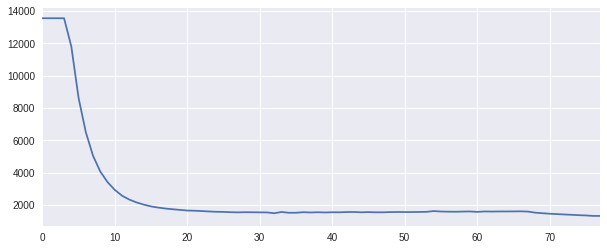

In [383]:
df_22.co_ppb.plot()

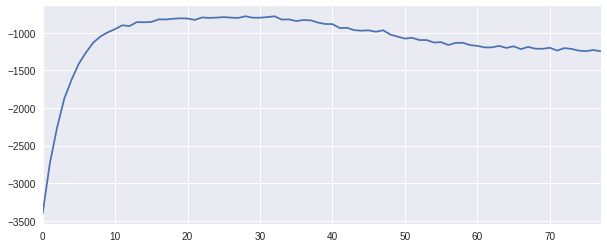

In [384]:
df_22.no2_ppb.plot()

In [411]:
df_22.NO2_mics_ppb.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: NO2_mics_ppb, dtype: float64

### Observations
- CO series odd, pattern looks like inverse of what expected, and high values
- Alphasense NO2... odd pattern, jumps immediately
- MICS NO2 sensors with zero reading

# Batch 2, serial 3 [Sensor box 30]  

In [543]:
df_23 = pd.read_csv("batch2/serial3.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_23['co_ppb'] = df_23[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_23['co_ppb_reverse'] = df_23[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_23['no2_ppb'] = df_23[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_23['no2_ppb_reverse'] = df_23[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb
# Resistances
df_23['NO2_mics_R1'] = df_23[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_23.MICSNO2.count()
minute = math.floor(obsN/5)
df_23['NO2_mics_R0'] = df_23.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_23['NO2_mics_ppb'] = df_23[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


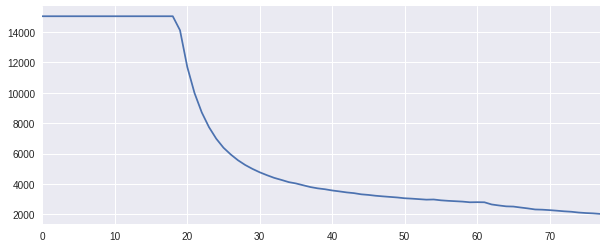

In [387]:
df_23.co_ppb.plot()
#df_23.no2_ppb.plot()
#df_23.NO2_mics_ppb.plot()

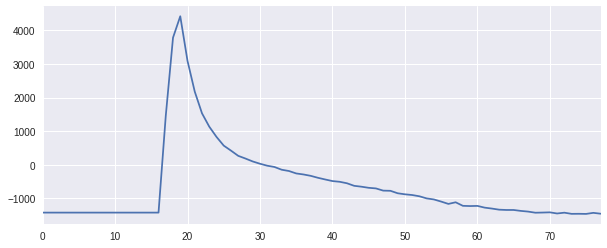

In [388]:
df_23.no2_ppb.plot()

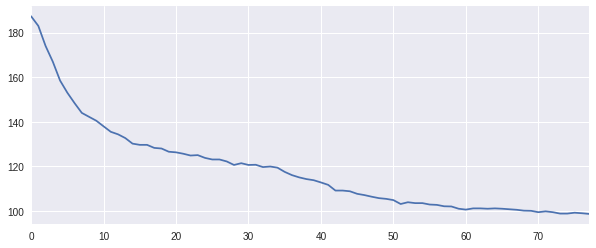

In [389]:
df_23.NO2_mics_ppb.plot()

### Observations
- CO series odd, pattern looks like inverse of what expected, and high values
- Alphasense NO2 looks to spike a bit too sharply, but levels might be reasonable with some tweaking of the conversions
- MICS NO2 sensor's values appear similar to other working MICS sensors

# Batch 2, serial 4 [Sensor box 21]  

In [544]:
df_24 = pd.read_csv("batch2/serial4.csv",
                names = ["GASCAL","ID","MICSNO2","MICSCO","ALPHANO2_AUX","ALPHANO2_WORKING","ALPHACO_AUX","ALPHACO_WORKING"])

# Alphasense CO in ppb
df_24['co_ppb'] = df_24[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID(x.values[0], x.values[1], x.values[2]), axis=1)
df_24['co_ppb_reverse'] = df_24[['ID','ALPHACO_WORKING','ALPHACO_AUX']].apply(lambda x: convert_co_ID_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# Alphasense NO2 in ppb
df_24['no2_ppb'] = df_24[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient(x.values[0], x.values[1], x.values[2]), axis=1)
df_24['no2_ppb_reverse'] = df_24[['ID','ALPHANO2_WORKING','ALPHANO2_AUX']].apply(lambda x: convert_no2_ambient_reverse(x.values[0], x.values[1], x.values[2]), axis=1)

# MICS NO2 in ppb
# Resistances
df_24['NO2_mics_R1'] = df_24[['MICSNO2']].apply(lambda x: resistance_from_voltage(x.values[0]),axis=1)

# Calculating the baseline offsets as the means of the observations during the first minute      
obsN = df_24.MICSNO2.count()
minute = math.floor(obsN/5)
df_24['NO2_mics_R0'] = df_24.NO2_mics_R1[0:minute].mean()

# Converting to ppb
df_24['NO2_mics_ppb'] = df_24[['NO2_mics_R1','NO2_mics_R0']].apply(lambda x: mics_no2_ppb(x.values[0], x.values[1]), axis=1)


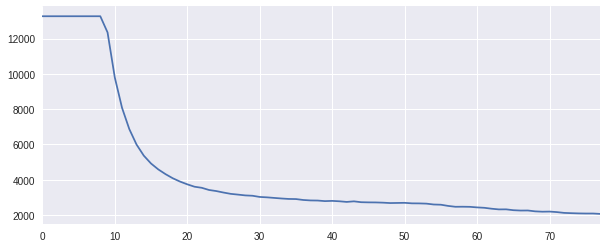

In [391]:
df_24.co_ppb.plot()
#df_24.no2_ppb.plot()
#df_24.NO2_mics_ppb.plot()

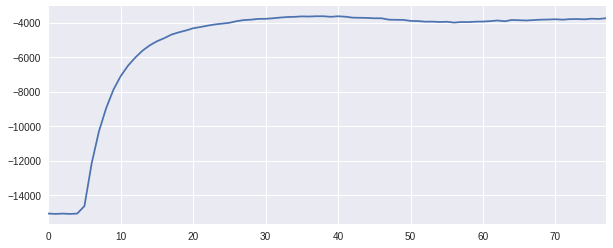

In [392]:
df_24.no2_ppb.plot()
#df_24.NO2_mics_ppb.plot()

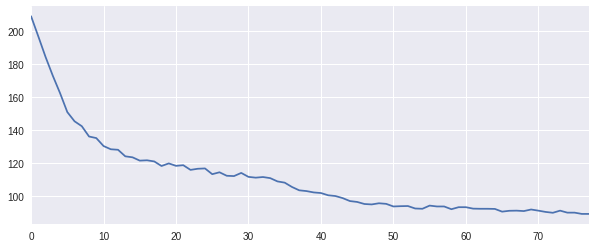

In [393]:
df_24.NO2_mics_ppb.plot()

### Observations
- CO series odd, again the pattern looks like inverse of what expected, and high values
- Alphasense NO2 looks to spike a bit too sharply, but levels might be reasonable with some tweaking of the conversions
- MICS NO2 sensor's values appear similar to other working MICS sensors

---

# Results

## Alphasense CO sensor readings

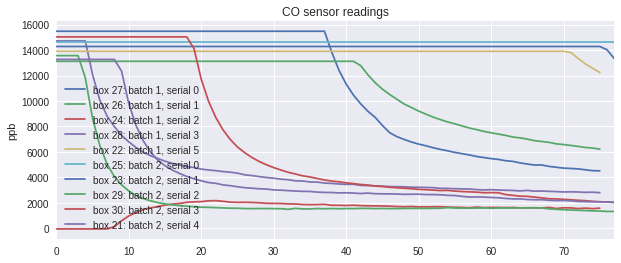

In [590]:
# Converted to ppb
df_10.co_ppb.plot(label='box 27: batch 1, serial 0')
df_11.co_ppb.plot(label='box 26: batch 1, serial 1')
df_12.co_ppb.plot(label='box 24: batch 1, serial 2')
df_13.co_ppb.plot(label='box 28: batch 1, serial 3')
df_15.co_ppb.plot(label='box 22: batch 1, serial 5')

df_20.co_ppb.plot(label='box 25: batch 2, serial 0')
df_21.co_ppb.plot(label='box 23: batch 2, serial 1')
df_22.co_ppb.plot(label='box 29: batch 2, serial 2')
df_23.co_ppb.plot(label='box 30: batch 2, serial 3')
df_24.co_ppb.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (ppb)')
plt.title('CO sensor readings, Alphasense')
plt.legend()

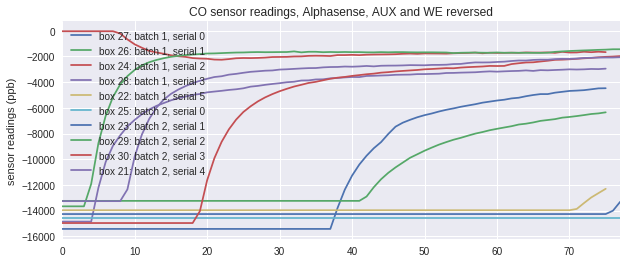

In [592]:
# Converted to ppb, reversed
df_10.co_ppb_reverse.plot(label='box 27: batch 1, serial 0')
df_11.co_ppb_reverse.plot(label='box 26: batch 1, serial 1')
df_12.co_ppb_reverse.plot(label='box 24: batch 1, serial 2')
df_13.co_ppb_reverse.plot(label='box 28: batch 1, serial 3')
df_15.co_ppb_reverse.plot(label='box 22: batch 1, serial 5')

df_20.co_ppb_reverse.plot(label='box 25: batch 2, serial 0')
df_21.co_ppb_reverse.plot(label='box 23: batch 2, serial 1')
df_22.co_ppb_reverse.plot(label='box 29: batch 2, serial 2')
df_23.co_ppb_reverse.plot(label='box 30: batch 2, serial 3')
df_24.co_ppb_reverse.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (ppb)')
plt.title('CO sensor readings, Alphasense, AUX and WE reversed')
plt.legend()

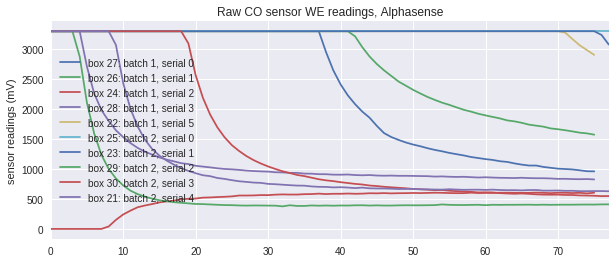

In [593]:
# Raw readings, to give context
df_10.ALPHACO_WORKING.plot(label='box 27: batch 1, serial 0')
df_11.ALPHACO_WORKING.plot(label='box 26: batch 1, serial 1')
df_12.ALPHACO_WORKING.plot(label='box 24: batch 1, serial 2')
df_13.ALPHACO_WORKING.plot(label='box 28: batch 1, serial 3')
df_15.ALPHACO_WORKING.plot(label='box 22: batch 1, serial 5')

df_20.ALPHACO_WORKING.plot(label='box 25: batch 2, serial 0')
df_21.ALPHACO_WORKING.plot(label='box 23: batch 2, serial 1')
df_22.ALPHACO_WORKING.plot(label='box 29: batch 2, serial 2')
df_23.ALPHACO_WORKING.plot(label='box 30: batch 2, serial 3')
df_24.ALPHACO_WORKING.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (mV)')
plt.title('Raw CO sensor WE readings, Alphasense')
plt.legend()

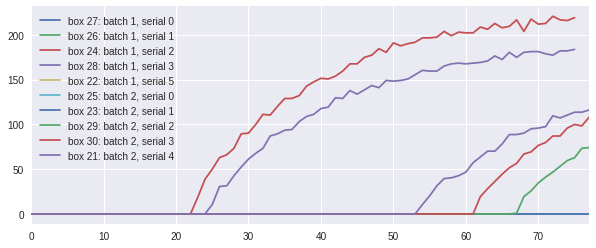

In [456]:
# Raw readings, to give context
df_10.ALPHACO_AUX.plot(label='box 27: batch 1, serial 0')
df_11.ALPHACO_AUX.plot(label='box 26: batch 1, serial 1')
df_12.ALPHACO_AUX.plot(label='box 24: batch 1, serial 2')
df_13.ALPHACO_AUX.plot(label='box 28: batch 1, serial 3')
df_15.ALPHACO_AUX.plot(label='box 22: batch 1, serial 5')

df_20.ALPHACO_AUX.plot(label='box 25: batch 2, serial 0')
df_21.ALPHACO_AUX.plot(label='box 23: batch 2, serial 1')
df_22.ALPHACO_AUX.plot(label='box 29: batch 2, serial 2')
df_23.ALPHACO_AUX.plot(label='box 30: batch 2, serial 3')
df_24.ALPHACO_AUX.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (mV)')
plt.title('Raw CO sensor AUX readings, Alphasense')
plt.legend()

### Observations on Alphasense CO readings
- Box 24 seems to be the only one that provides reasonable-looking values
- Boxes other than 24 may have their AUX and Working electrodes readings reversed.
    - however, the combined readings are such that the values become nonsensical when reversed as well, as the electrode readings are in the extremes for a lot of the time - if not zero, then 3300  
- Boxes 22, 23, 25 and 26 have zero AUX readings throughout the test, causing the conversions to yield odd values.
- Box 22, 23 and 25 have WE readings that are flat, with small change at the end for 22 and 23

## Alphasense NO2 sensor readings vary wildly 

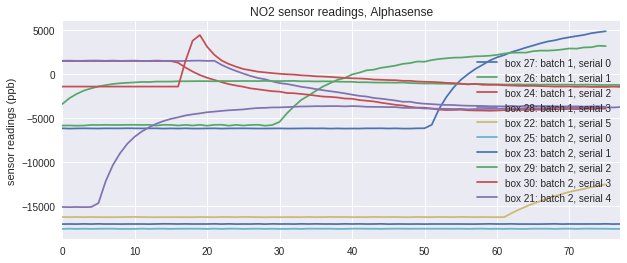

In [594]:
# Converted to ppb
df_10.no2_ppb.plot(label='box 27: batch 1, serial 0')
df_11.no2_ppb.plot(label='box 26: batch 1, serial 1')
df_12.no2_ppb.plot(label='box 24: batch 1, serial 2')
df_13.no2_ppb.plot(label='box 28: batch 1, serial 3')
df_15.no2_ppb.plot(label='box 22: batch 1, serial 5')

df_20.no2_ppb.plot(label='box 25: batch 2, serial 0')
df_21.no2_ppb.plot(label='box 23: batch 2, serial 1')
df_22.no2_ppb.plot(label='box 29: batch 2, serial 2')
df_23.no2_ppb.plot(label='box 30: batch 2, serial 3')
df_24.no2_ppb.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (ppb)')
plt.title('NO2 sensor readings, Alphasense')
plt.legend()

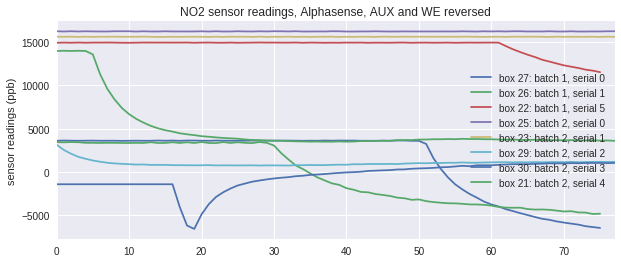

In [595]:
# Converted to ppb, reversed
df_10.no2_ppb_reverse.plot(label='box 27: batch 1, serial 0')
df_11.no2_ppb_reverse.plot(label='box 26: batch 1, serial 1')
##df_12.no2_ppb_reverse.plot(label='box 24: batch 1, serial 2')
##df_13.no2_ppb_reverse.plot(label='box 28: batch 1, serial 3')
df_15.no2_ppb_reverse.plot(label='box 22: batch 1, serial 5')

df_20.no2_ppb_reverse.plot(label='box 25: batch 2, serial 0')
df_21.no2_ppb_reverse.plot(label='box 23: batch 2, serial 1')
df_22.no2_ppb_reverse.plot(label='box 29: batch 2, serial 2')
df_23.no2_ppb_reverse.plot(label='box 30: batch 2, serial 3')
df_24.no2_ppb_reverse.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (ppb)')
plt.title('NO2 sensor readings, Alphasense, AUX and WE reversed')
plt.legend()

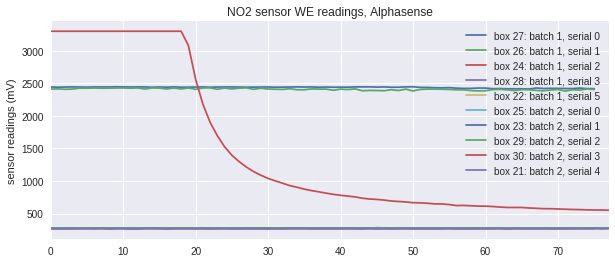

In [596]:
# Raw readings, to give context
df_10.ALPHANO2_WORKING.plot(label='box 27: batch 1, serial 0')
df_11.ALPHANO2_WORKING.plot(label='box 26: batch 1, serial 1')
df_12.ALPHANO2_WORKING.plot(label='box 24: batch 1, serial 2')
df_13.ALPHANO2_WORKING.plot(label='box 28: batch 1, serial 3')
df_15.ALPHANO2_WORKING.plot(label='box 22: batch 1, serial 5')

df_20.ALPHANO2_WORKING.plot(label='box 25: batch 2, serial 0')
df_21.ALPHANO2_WORKING.plot(label='box 23: batch 2, serial 1')
df_22.ALPHANO2_WORKING.plot(label='box 29: batch 2, serial 2')
df_23.ALPHANO2_WORKING.plot(label='box 30: batch 2, serial 3')
df_24.ALPHANO2_WORKING.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (mV)')
plt.title('NO2 sensor WE readings, Alphasense')
plt.legend()

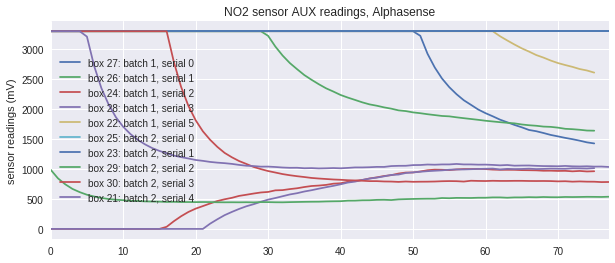

In [597]:
# Raw readings, to give context
df_10.ALPHANO2_AUX.plot(label='box 27: batch 1, serial 0')
df_11.ALPHANO2_AUX.plot(label='box 26: batch 1, serial 1')
df_12.ALPHANO2_AUX.plot(label='box 24: batch 1, serial 2')
df_13.ALPHANO2_AUX.plot(label='box 28: batch 1, serial 3')
df_15.ALPHANO2_AUX.plot(label='box 22: batch 1, serial 5')

df_20.ALPHANO2_AUX.plot(label='box 25: batch 2, serial 0')
df_21.ALPHANO2_AUX.plot(label='box 23: batch 2, serial 1')
df_22.ALPHANO2_AUX.plot(label='box 29: batch 2, serial 2')
df_23.ALPHANO2_AUX.plot(label='box 30: batch 2, serial 3')
df_24.ALPHANO2_AUX.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (mV)')
plt.title('NO2 sensor AUX readings, Alphasense')
plt.legend()

### Observations on Alphasense NO2 readings
- Box 30 readings seem most reasonable, although the pattern is not smooth (has a spike)
- All boxes, except possibly 30, show results suggesting their AUX and WE may be reversed
- Assuming that the electrodes were reversed, some more sensible results appear with boxes 28 and 24, which both were in batch 1
    - box 30 looks like it might have the inverse pattern as well, although with a dip before a smooth rise 
    - other boxes' readings show patterns of long flat periods at high levels before a smoot decrease
    - none of these decreases appear to happen at a similar time


# Working MICS NO2 sensors provide largely similar readings

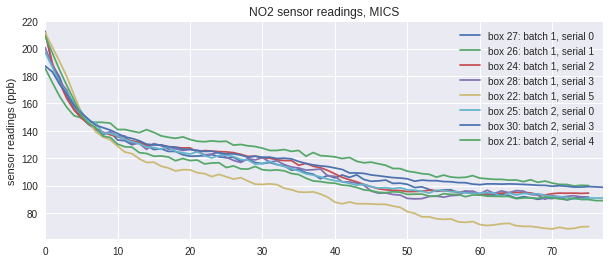

In [598]:
df_10.NO2_mics_ppb.plot(label='box 27: batch 1, serial 0')
df_11.NO2_mics_ppb.plot(label='box 26: batch 1, serial 1')
df_12.NO2_mics_ppb.plot(label='box 24: batch 1, serial 2')
df_13.NO2_mics_ppb.plot(label='box 28: batch 1, serial 3')
df_15.NO2_mics_ppb.plot(label='box 22: batch 1, serial 5')

df_20.NO2_mics_ppb.plot(label='box 25: batch 2, serial 0')
df_23.NO2_mics_ppb.plot(label='box 30: batch 2, serial 3')
df_24.NO2_mics_ppb.plot(label='box 21: batch 2, serial 4')
plt.ylabel('sensor readings (ppb)')
plt.title('NO2 sensor readings, MICS')
plt.legend()

### Observations on MICS NO2 readings
- all boxes provide broadly similar readings
- however, the values are not sensible as the R0 calibration was unsuccessful (the R0 was taken as an average from what was estimated to be the first minute, but the readings are not stable during it)
- box 22 seems to have a lower reading than others for large part of the time, while box 26 somewhat higher

## Outputting the full data

In [580]:
all_boxes = [df_10[0:76], df_11[0:76], df_12[0:76], df_13[0:76], df_15[0:76], df_20[0:76], df_21[0:76], df_22[0:76], df_23[0:76], df_24[0:76]]
# only up to 76th index due to some series being longer, causing issues with R^2 and S-K tests below
comb = pd.concat(all_boxes)
combined_data = comb.reindex_axis(df_10.columns, axis=1) #reordering columns after concat auto-order

In [581]:
combined_data.to_csv('03_torching_data_out.csv')

# R^2 and S-K -tests
## Matrices showing R^2 and K-S p-values between each pair of boxes

In [582]:
IDs = combined_data.ID.unique().tolist()
IDn = len(IDs)

In [583]:
# Matrix of R^2 values of CO series
r2_arr_CO = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])
ks_arr_CO = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])

for i in range(0,IDn):
    for j in range(0,IDn):
        data_i = combined_data.loc[combined_data['ID'] == IDs[i]]
        data_j = combined_data.loc[combined_data['ID'] == IDs[j]] 
        if data_i.ID.count() == data_j.ID.count():
            r2_arr_CO[i][j] = r2_score(data_i['co_ppb'], data_j['co_ppb'])
            ks_statistic, ks_arr_CO[i][j] = scipy.stats.ks_2samp(data_i['co_ppb'], data_j['co_ppb'])
        else:
            r2_arr_CO[i][j] = np.NaN
            ks_arr_CO[i][j] = np.NaN
r2_df_CO = pd.DataFrame()
r2_df_CO = r2_arr_CO.to_pandas()
print("The R^2 values for the Alphasense CO series are:\n ")
print(r2_df_CO)

ks_df_CO = pd.DataFrame()
ks_df_CO = ks_arr_CO.to_pandas()
print("\n\nThe K-S statistic p-values for the Alphasense CO series are:\n ")
print(ks_df_CO)



The R^2 values for the Alphasense CO series are:
 
ID_comp            27            26            24            28            22  \
ID_base                                                                         
27       1.000000e+00  7.647578e-01 -4.145098e+00 -1.481182e+00 -3.189676e-01   
26       2.840484e-01  1.000000e+00 -1.220384e+01 -5.341701e+00 -1.100971e+00   
24      -2.966929e+02 -2.500191e+02  1.000000e+00 -6.210105e+01 -3.951954e+02   
28      -4.685464e+00 -3.774684e+00 -1.499016e+00  1.000000e+00 -8.382752e+00   
22      -3.981705e+02 -2.079180e+02 -2.071330e+03 -1.238217e+03  1.000000e+00   
25      -1.049353e+31 -6.270912e+30 -5.161302e+31 -3.175270e+31 -1.933607e+29   
23      -9.846946e+30 -5.600237e+30 -4.915020e+31 -2.991758e+31 -7.977993e+28   
29      -9.106605e+00 -7.779983e+00 -5.337101e-01  4.075360e-01 -1.375024e+01   
30      -1.763407e-01 -2.337891e-01 -1.170116e+00  4.102825e-01 -1.838169e+00   
21      -3.606100e+00 -3.022506e+00 -1.005405e+00  8.58328

In [584]:
# Matrix of R^2 values of NO2 series
r2_arr_NO2 = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])
ks_arr_NO2 = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])

for i in range(0,IDn):
    for j in range(0,IDn):
        data_i = combined_data.loc[combined_data['ID'] == IDs[i]]
        data_j = combined_data.loc[combined_data['ID'] == IDs[j]] 
        if data_i.ID.count() == data_j.ID.count():
            r2_arr_NO2[i][j] = r2_score(data_i['no2_ppb'], data_j['no2_ppb'])
            ks_statistic, ks_arr_NO2[i][j] = scipy.stats.ks_2samp(data_i['no2_ppb'], data_j['no2_ppb'])
        else:
            r2_arr_NO2[i][j] = np.NaN
            ks_arr_NO2[i][j] = np.NaN
r2_df_NO2 = pd.DataFrame()
r2_df_NO2 = r2_arr_NO2.to_pandas()
print("The R^2 values for the Aplhasense NO2 series are:\n ")
print(r2_df_NO2)

ks_df_NO2 = pd.DataFrame()
ks_df_NO2 = ks_arr_NO2.to_pandas()
print("\n\nThe K-S statistic p-values for the Alphasense NO2 series are:\n ")
print(ks_df_NO2)

The R^2 values for the Aplhasense NO2 series are:
 
ID_comp            27            26            24            28            22  \
ID_base                                                                         
27       1.000000e+00  3.312289e-01 -1.073553e+00 -1.260401e+00     -8.614659   
26       1.728373e-01  1.000000e+00 -1.406323e+00 -1.479713e+00    -14.400363   
24      -6.466005e+00 -6.005089e+00  1.000000e+00  8.732728e-01    -41.586047   
28      -7.138490e+00 -6.218491e+00  8.732772e-01  1.000000e+00    -45.114711   
22      -1.594918e+02 -2.068436e+02 -1.964300e+02 -2.127963e+02      1.000000   
25      -1.734597e+06 -2.152888e+06 -2.014066e+06 -2.162623e+06 -33202.875547   
23      -2.438274e+06 -3.046138e+06 -2.839498e+06 -3.056314e+06 -30459.122743   
29      -1.359668e+02 -8.170122e+01 -3.366903e+01 -2.861408e+01  -1267.723773   
30      -2.034557e+01 -1.276984e+01 -4.042816e+00 -2.459849e+00   -161.710454   
21      -1.210026e+00 -1.411134e+00 -2.439595e+00 -2.7047

In [585]:
# Matrix of R^2 values of MICS series
r2_arr_MICS_NO2 = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])
ks_arr_MICS_NO2 = xr.DataArray(np.zeros((IDn,IDn)),[('ID_base', IDs),('ID_comp', IDs)])

for i in range(0,IDn):
    for j in range(0,IDn):
        data_i = combined_data.loc[combined_data['ID'] == IDs[i]]
        data_j = combined_data.loc[combined_data['ID'] == IDs[j]] 
        if data_i.ID.count() == data_j.ID.count() and data_i.NO2_mics_ppb.count() > 0.0 and data_j.NO2_mics_ppb.count() > 0.0:
            r2_arr_MICS_NO2[i][j] = r2_score(data_i['NO2_mics_ppb'], data_j['NO2_mics_ppb'])
            ks_statistic, ks_arr_MICS_NO2[i][j] = scipy.stats.ks_2samp(data_i['NO2_mics_ppb'], data_j['NO2_mics_ppb'])
        else:
            r2_arr_MICS_NO2[i][j] = np.NaN
            ks_arr_MICS_NO2[i][j] = np.NaN
r2_df_MICS_NO2 = pd.DataFrame()
r2_df_MICS_NO2 = r2_arr_MICS_NO2.to_pandas()
print("The R^2 values for the MICS series are:\n ")
print(r2_df_MICS_NO2)

ks_df_MICS_NO2 = pd.DataFrame()
ks_df_MICS_NO2 = ks_arr_MICS_NO2.to_pandas()
print("\n\nThe K-S statistic p-values for the MICS series are:\n ")
print(ks_df_MICS_NO2)

The R^2 values for the MICS series are:
 
ID_comp        27        26        24        28        22        25  23  29  \
ID_base                                                                       
27       1.000000  0.767402  0.977941  0.969448  0.507198  0.982979 NaN NaN   
26       0.615874  1.000000  0.684273  0.578069 -1.214835  0.602042 NaN NaN   
24       0.977878  0.808270  1.000000  0.983783  0.413932  0.978558 NaN NaN   
28       0.970305  0.751677  0.984283  1.000000  0.529742  0.987376 NaN NaN   
22       0.725928  0.254124  0.674992  0.730917  1.000000  0.733957 NaN NaN   
25       0.982529  0.752658  0.978054  0.986668  0.508993  1.000000 NaN NaN   
23            NaN       NaN       NaN       NaN       NaN       NaN NaN NaN   
29            NaN       NaN       NaN       NaN       NaN       NaN NaN NaN   
30       0.897200  0.903382  0.918855  0.884237 -0.216514  0.905591 NaN NaN   
21       0.964452  0.626459  0.938979  0.960880  0.712691  0.968793 NaN NaN   

ID_comp  

---

## Statement of work

Statement of work "Analyse 0.3 torching data"

Deliverables: Analyse torching data from 10 new 0.3 sensors. This is the same task as the take home, just with new model of sensors. 1 minute ambient, 1 minute torching, 3 mins nothing. 
Two separate tests were done. Each with a different batch of sensors. (Only 5 sensors could fit into a test chamber at a time.)

The sensors are:

- Gas alphasense sensors as in the take home.  Sensor =21 has NO2-A42F, the rest have NO2-A43F. In the same way, sensor 21 has CO-A42F and the rest have NO2-A43F. I will send calibration sheets later tonight.
- MICS sensor is 4514. Mics 1 is OX and MICS 2 is RED. Should agree with gas alphasense.
- [http:///]Winsen PM
- Alphasense OPC-N2
- pump. (1.5 litre per minute, turning on for 10 secs every minute.) It takes more than a minute to exchange the air because it is about a litre of air inside the box. The box is not airtight and there is airflow from the car moving as well.

- humidity and temp sensor RHT03


See logs attached - just do a quick grep to transform the GASCAL line to a csv.
'GASCAL,25,1518.242,1523.883,3300.000,273.187,  0.000,3300.000' has the header:
GASCAL,%7.3f,%7.3f,%7.3f,%7.3f,%7.3f,%7.3f
GASCAL,ID,MICSNO2,MICSCO,ALPHANO2_AUX,ALPHANO2_WORKING,ALPHACO_AUX,ALPHACO_WORKING

 Find faulty sensors. Apply some correction in order to get correct data from each one of the sensors.

Budget: 10 hours.

Delivery date: Sunday 12 Feb 19:00

**NOTE: Also provide R^2/K-S test results across sensors.**

1. "It looks like for some sensors the aux/working electrodes are switched around during assembly. Can you: 
    - find which sensor ids they are, 
    - verify they are still switched in this mornings 12feb_morning.csv and then ping matt in the hardware channel to fix this?"